In [1]:
import numpy as np
import torch 
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import get_linear_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup, get_cosine_schedule_with_warmup
from torch.optim import Adam, AdamW

import math
from tqdm import trange 
import gc
import time

import pandas as pd

import gzip
import pickle

import logging
import copy

from torch.optim.lr_scheduler import StepLR

from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
logging.basicConfig(filename='music_logs_selfAttention.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Testing")

Time       ->  Window Frame Size <br>
1 seconds  ->  32  <br>
3 seconds  ->  94  <br>
6 seconds  ->  188 <br>
9 seconds  ->  282 <br>
12 seconds ->  375 <br>
15 seconds ->  469 <br>

In [3]:
SHOW_PROCCESS = bool(True)
PROCESS_STEP = int(100)

TYPE_METRIC = str("f1")
FINE_TUNNING = bool(True)
SAVE_BEST_MODEL = bool(True)
# WINDOW_FRAME = int(188)#int(94) #15 seconds

# MODEL TRAINING
EPOCHS = int(10)
BATCH_SIZE = int(400)
lr = float(2.3e-6)

model_config = {
    "in_channels_cnn" : int(1),
    "out_channels_cnn" : int(128),
    "num_heads" : int(4),
    "classes" : int(20)
}


# INIT SCHEDULER FOR TEST DIFFERENT LR

POWER = float(4.0)
NUM_WARMUP_STEPS= float(2) 
NUM_TRAINING_STEPS = EPOCHS

LEARNING_RATE_OR_SCHEDULE = True #schedule

Load files that contains path for songs

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
validation_df = pd.read_csv("./dataset/validation.csv")

In [6]:
train_df = train_df.sample(frac=1, random_state=54)
test_df = test_df.sample(frac=1, random_state=54)
validation_df = validation_df.sample(frac=1, random_state=54)

In [7]:
train_df.head(5)


,Unnamed: 0,label,path
85408,85408,beatles,./dataset/train/beatles-All_You_Need_Is_Love-3...
48414,48414,steely_dan,./dataset/train/steely_dan-The_Royal_Scam-3sec...
61239,61239,garth_brooks,./dataset/train/garth_brooks-Anonymous-3sec-0....
57538,57538,aerosmith,./dataset/train/aerosmith-Voodoo_Medicine_Man-...
8684,8684,roxette,./dataset/train/roxette-fading_like_a_flower_e...


Create data for loading in DataLoader

In [8]:
train_spectrogram_path = train_df.path.values 
train_spectrogram_labels = train_df.label.values 

test_spectrogram_path = test_df.path.values 
test_spectrogram_labels = test_df.label.values 

validation_spectrogram_path = validation_df.path.values 
validation_spectrogram_labels = validation_df.label.values 

In [9]:
encoder = OneHotEncoder(sparse_output = False).fit(train_spectrogram_labels.reshape(-1, 1))
encoder.categories_

[array(['aerosmith', 'beatles', 'creedence_clearwater_revival', 'cure',
        'dave_matthews_band', 'depeche_mode', 'fleetwood_mac',
        'garth_brooks', 'green_day', 'led_zeppelin', 'madonna',
        'metallica', 'prince', 'queen', 'radiohead', 'roxette',
        'steely_dan', 'suzanne_vega', 'tori_amos', 'u2'], dtype=object)]

In [10]:
train_labels_encoded = encoder.transform(train_spectrogram_labels.reshape(-1, 1))
test_labels_encoded = encoder.transform(test_spectrogram_labels.reshape(-1, 1))
validation_labels_encoded = encoder.transform(validation_spectrogram_labels.reshape(-1, 1))

#### Define Class for opening file and create DataLoader

In [11]:
class SongDatasetLoader(Dataset):
    """Load songs spectrograms from path"""
    def __init__(self, data: np.ndarray, labels: np.ndarray, transform: bool = True) -> None:
        self.data = data
        self.labels = labels
        self.transform = transform
        self.DTYPE = torch.float
   
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx:int):
        data_path_idx = self.data[idx]
        labels = self.labels[idx]

        with gzip.open(data_path_idx, 'rb') as f:
            decompressed_data = pickle.load(f)
            decompressed_data = decompressed_data['spectrogram']

    
        if self.transform:
            decompressed_data = torch.tensor(decompressed_data, dtype=self.DTYPE )
            labels = torch.tensor(labels, dtype = self.DTYPE )
           

        return decompressed_data, labels

    

In [12]:
train_load_data = SongDatasetLoader(train_spectrogram_path, train_labels_encoded)
test_load_data = SongDatasetLoader(test_spectrogram_path, test_labels_encoded)
Validation_load_data = SongDatasetLoader(validation_spectrogram_path, validation_labels_encoded)

In [13]:
train_dataLoader = DataLoader(train_load_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataLoader = DataLoader(test_load_data, batch_size = BATCH_SIZE, shuffle = False)
validation_dataLoader = DataLoader(Validation_load_data, batch_size = BATCH_SIZE, shuffle = True)

#### Model Design

In [18]:
from torch.autograd import Variable

class CNN(nn.Module):
    
    def __init__(self, in_channels:int, out_channels:int)-> Tensor:
        super(CNN, self).__init__()
        padding = [(1,1), (0,0)]
        number_filters = [int(64), int(64),  out_channels]

        self.cnn = nn.Sequential(OrderedDict([
            ("batch_norm",nn.BatchNorm2d(1)),
            ("conv_1", nn.Conv2d(in_channels = in_channels, out_channels=number_filters[0], kernel_size=(3,3), padding=padding[0])),
            ("act_1", nn.ELU()),
            ("max_pooling_1",nn.MaxPool2d(kernel_size=(4,4), stride=(4,2), padding = padding[0])),
            ("dropout_1",nn.Dropout(p = 0.2)),

            ("conv_2", nn.Conv2d(in_channels = number_filters[0], out_channels=number_filters[1], kernel_size=(4,4), padding=padding[0])),
            ("act_2", nn.ELU()),
            ("max_pooling_2",nn.MaxPool2d(kernel_size=(4,2), stride=(4,1), padding = padding[0])),
            ("dropout_2",nn.Dropout(p = 0.2)),

            ("conv_3", nn.Conv2d(in_channels = number_filters[1], out_channels=number_filters[2], kernel_size=(4,4), padding=padding[0])),
            ("act_3", nn.ELU()),
            ("max_pooling_3",nn.MaxPool2d(kernel_size=(4,2), stride=(4,1), padding = padding[1])),
            ("dropout_3",nn.Dropout(p = 0.2)),

        ]))


    def forward(self, src:Tensor) -> Tensor:
        
        src = src.unsqueeze(1)
        src =  self.cnn(src)
        src = src.squeeze(2)   
        return src 
        


class PositionalEncoding(nn.Module):
    def __init__(self, d_model:int, max_len:int=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        x = x + self.encoding[:, :x.size(1), :].to(device)
        return x
    



class SelfAttentionClassifier(nn.Module):
    def __init__(self, max_seq_len, embedding_dim, num_heads, dropout=0.3, output: int=20):
        super(SelfAttentionClassifier, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Linear(max_seq_len, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim) 
        self.self_attention = nn.MultiheadAttention(embed_dim = embedding_dim, 
                                                    num_heads = num_heads, 
                                                    dropout = dropout)
        
        self.fc = nn.Linear(embedding_dim, output)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(embedding_dim)
        

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.embedding_dim)
        # src = self.norm(src)
        src = self.pos_encoder(src)
        src = src.permute(2,0,1)
        attn_output, attn_output_weights = self.self_attention(src, src, src)  # Self-attention
        attn_output = attn_output.mean(dim=0) 
        attn_output = self.dropout(attn_output)
        out = self.fc(attn_output)
        return out, attn_output_weights

    


class VisualEncoderModel(nn.Module):
    def __init__(self, 
                 in_channels_cnn: int, 
                 out_channels_cnn:int, 
                 classes:int = 20, 
                 num_heads : int=2,
                
                 )-> Tensor:
        
        super(VisualEncoderModel, self).__init__()
        self.cnn = CNN(in_channels_cnn, out_channels_cnn)
        
        self.encoder = SelfAttentionClassifier(max_seq_len = 45, 
                                          embedding_dim = out_channels_cnn, 
                                          num_heads = num_heads,   
                                          output=classes)
                
    def forward(self, src: torch.Tensor):
        src = self.cnn(src) 
        src, attn_output_weights = self.encoder(src)
        return src, attn_output_weights
       

In [ ]:
# model = VisualEncoderModel(**model_config)

# model = nn.DataParallel(model)
# model.to(device)

# for epoch in trange(2, desc="Epoch"):
  
#   model.train()
 
#   for step, batch in enumerate(train_dataLoader):
#     batch = tuple(t.to(device) for t in batch)
#     input_ids, labels = batch
    
    
#     output = model(input_ids)
#     print(output.size())
#     loss = criterion(output, labels)

    
#     # print(output)

#     break
  

INIT MODEL

In [ ]:

# model = VisualEncoderModel(**model_config)

# model = nn.DataParallel(model)
# model.to(device)
# logging.info(model.parameters)

# model.parameters

Load Model

In [ ]:
model_txt = "./model_selfAttention/150_epoch_0.00022996158227750666_lr_1716655217_timestap.pt"
model = torch.load(model_txt)
model = nn.DataParallel(model)
model.to(device)
logging.info(f"Loading model {model_txt}")
logging.info( model.parameters)
model.parameters

In [ ]:
lr

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr = lr, weight_decay=0.023 )
# optimizer = Adam(model.parameters(), lr = lr, weight_decay=0.02 )

total_steps = len(train_load_data) * EPOCHS

# scheduler = get_polynomial_decay_schedule_with_warmup(optimizer,
#                                                       num_warmup_steps=0,
#                                                       num_training_steps=total_steps,
#                                                       power=POWER)



scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


# scheduler = get_cosine_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps=NUM_WARMUP_STEPS,
#                                             num_training_steps=NUM_TRAINING_STEPS)

# Define the step size and gamma for the scheduler
# step_size = 20
# gamma = 0.1

# # Define the scheduler
# scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)


gc.collect()
torch.cuda.empty_cache()

Model

In [24]:
def metrics(labels : Tensor , output : Tensor, typeMetric: str = 'f1' ) -> float:
  from sklearn.metrics import f1_score

  y_pred = output.detach().cpu().numpy()
  y_true = labels.detach().cpu().numpy()

  pred_flat = np.argmax(y_pred, axis=1).flatten()
  labels_flat = np.argmax(y_true, axis=1).flatten()

  # print(pred_flat)
  # print(labels_flat)
  # print("---------------------")
 
  if typeMetric == 'f1':
    return f1_score(labels_flat, pred_flat, average='macro')
  if typeMetric == 'acc':
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [52]:

best_epoch = int(0)
best_by_metric = float('-inf')
# best_by_metric = float(0.3875209701744368)
best_model = copy.deepcopy(model.state_dict())
file_name = str("")
check_if_model_saved = bool(False)

train_loss_set = []

for epoch in trange(EPOCHS, desc="Epoch"):
  print(f'Training Process: epochs {epoch}/{EPOCHS - 1}')
  # Training --------------------------------------------------------------------------------------------------------

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()


  
  training_loss = float(0)
  training_metric_evaluation = float(0)
  training_accuracy_evaluation = float(0)
  log_interval = PROCESS_STEP
  start_time = time.time()

  # Train the data for one epoch
  for step, batch in enumerate(train_dataLoader):
    
    batch = tuple(t.to(device) for t in batch)
    input_ids, labels = batch
    output, _ = model(input_ids)

    loss = criterion(output, labels)

    optimizer.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()

    training_loss += loss.item()

    training_metric_evaluation += metrics(labels, output, typeMetric = TYPE_METRIC)
    training_accuracy_evaluation  += metrics(labels, output, typeMetric = 'acc')
    train_loss_set.append(loss.item())

    
    if SHOW_PROCCESS and (step % log_interval == 0 and step > 0):
        lr_show = scheduler.get_last_lr()[0] if LEARNING_RATE_OR_SCHEDULE else lr
        ms_per_batch = (time.time() - start_time) * 1000 / log_interval # time in miliseconds
        txt = f'Training stage: | epoch {epoch:3d}/{EPOCHS - 1} | {step:5d}/{len(train_dataLoader):5d} batches |'\
              f'lr {lr_show:02.9f} | ms/batch {ms_per_batch:5.2f} | loss {loss.item():5.9f} |'\
              f' accuracy {(training_accuracy_evaluation / step):2.4f} | {TYPE_METRIC} {(training_metric_evaluation/step):2.4f}' 

        logging.info(txt)
        print(txt) 
        
    if LEARNING_RATE_OR_SCHEDULE:
      scheduler.step()

  txt = f"Train loss {training_loss/len(train_dataLoader)} | accuracy {training_accuracy_evaluation/len(train_dataLoader)} | {TYPE_METRIC} {training_metric_evaluation/len(train_dataLoader)} |"
  logging.info(txt)
  print(txt)
    
  # clean memory
  gc.collect()
  torch.cuda.empty_cache()
  
  print('-' * 150)
  logging.info('-' * 150)
  # Validation -----------------------------------------------------------------------------------------------------------
  print(f'Validation Process: epochs {epoch}/{EPOCHS - 1}')
  validation_loss = float(0)
  metric_evaluation = float(0)
  accuracy_evaluation = float(0)


  start_time = time.time()
  log_interval = PROCESS_STEP

  # Evaluate data for one epoch
  model.eval()
  with torch.no_grad(): #  not to compute or store gradients
    for step, batch in enumerate(validation_dataLoader):
    
      batch = tuple(t.to(device) for t in batch)
      input_ids, labels = batch #unpack from Dataloader
    
      output, _ = model(input_ids)
      loss = criterion(output, labels)

      validation_loss += loss.item()
      metric_evaluation += metrics(labels, output, typeMetric = TYPE_METRIC)
      accuracy_evaluation  += metrics(labels, output, typeMetric = 'acc')
      
      

      if SHOW_PROCCESS and (step % log_interval == 0 and step > 0):
        lr_show = scheduler.get_last_lr()[0] if LEARNING_RATE_OR_SCHEDULE else lr
        ms_per_batch = (time.time() - start_time) * 1000 / log_interval # time in miliseconds
        txt = f'Validation stage: | epoch {epoch:3d}/{EPOCHS - 1} | {step:5d}/{len(validation_dataLoader):5d} batches |'\
              f'lr {lr_show:02.9f} | ms/batch {ms_per_batch:5.2f} | loss {loss.item():5.9f} |'\
              f'Validation Evaluation {TYPE_METRIC}: {(metric_evaluation/step):3.5f} |'\
              f'acc: {(accuracy_evaluation/step):3.5f} |'
        
        logging.info(txt)
        print(txt)  

    
    if SAVE_BEST_MODEL and ((metric_evaluation/len(validation_dataLoader)) > best_by_metric):
      best_by_metric = metric_evaluation/len(validation_dataLoader)
      best_Model =  copy.deepcopy(model.state_dict())
      best_epoch = epoch

      lr_show = scheduler.get_last_lr()[0] if LEARNING_RATE_OR_SCHEDULE else lr
      file_name = f'./model_selfAttention/{epoch}_epoch_{lr_show}_lr_{int(time.time())}_timestap.pt'
      torch.save(model, file_name)
      logging.info(f'File saved {file_name}')
      print(f'File saved {file_name}') 
      check_if_model_saved = True


    txt = f'Validation Evaluation {TYPE_METRIC}: {(metric_evaluation/len(validation_dataLoader)):3.5f} |' \
    f'acc: {(accuracy_evaluation/len(validation_dataLoader)):3.5f} | loss: {(validation_loss/len(validation_dataLoader)):3.9} |'\
    f'Execution time: {(time.time() - start_time):5.2f}'  

    logging.info(txt)
    print(txt)

  

  # clean memory
  gc.collect()
  torch.cuda.empty_cache()

  if check_if_model_saved:
    txt = f'Best model saved: | {best_epoch} epoch | metric {TYPE_METRIC}: {best_by_metric} | model file saved: {file_name}'
    logging.info(txt)
    print(txt)
    check_if_model_saved = False
  
  
  print('=' * 150)
  logging.info('=' * 150)



Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Process: epochs 0/9


Epoch:   0%|          | 0/10 [00:02<?, ?it/s]


KeyboardInterrupt: 

RESULTS

In [14]:
def testing() -> None:
    test_loss = float(0)
    metric_evaluation = float(0)
    accuracy_evaluation = float(0)

    start_time = time.time()

    response = {
      "all_labels" : list([]),
      "all_predictions" : list([])
    }
    


    # Evaluate data for one epoch
    model.eval()
    with torch.no_grad(): #  not to compute or store gradients
      for _, batch in enumerate(test_dataLoader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, labels = batch #unpack from Dataloader
        output, attn_output_weights = model(input_ids)
        loss = criterion(output, labels)
        
        test_loss += loss.item()
        
        metric_evaluation += metrics(labels, output, typeMetric = TYPE_METRIC)
        accuracy_evaluation  += metrics(labels, output, typeMetric = 'acc')

        predictions = torch.argmax(output, dim=1)
        labels_ = torch.argmax(labels, dim=1)
        response["all_labels"].extend(labels_.cpu().numpy())
        response["all_predictions"].extend(predictions.cpu().numpy())

        
        

    txt = f'Test Evaluation {TYPE_METRIC}: {(metric_evaluation/len(test_dataLoader)):3.5f} |' \
    f'acc: {(accuracy_evaluation/len(test_dataLoader)):3.5f} | loss: {(test_loss/len(test_dataLoader)):3.5} |'\
    f'Execution time: {(time.time() - start_time):5.2f}'
    logging.info(txt)
    print(txt)
      
    # clean memory
    gc.collect()
    torch.cuda.empty_cache()

    return response


In [22]:
model = torch.load("./model_selfAttention/0_epoch_2.299423960260221e-06_lr_1716685794_timestap.pt").to(device)
model.parameters

<bound method Module.parameters of DataParallel(
  (module): DataParallel(
    (module): VisualEncoderModel(
      (cnn): CNN(
        (cnn): Sequential(
          (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act_1): ELU(alpha=1.0)
          (max_pooling_1): MaxPool2d(kernel_size=(4, 4), stride=(4, 2), padding=(1, 1), dilation=1, ceil_mode=False)
          (dropout_1): Dropout(p=0.2, inplace=False)
          (conv_2): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
          (act_2): ELU(alpha=1.0)
          (max_pooling_2): MaxPool2d(kernel_size=(4, 2), stride=(4, 1), padding=(1, 1), dilation=1, ceil_mode=False)
          (dropout_2): Dropout(p=0.2, inplace=False)
          (conv_3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
          (act_3): ELU(alpha=1.0)
          (max_pooling_3): MaxPool2d(kernel

In [25]:
response = testing()

Test Evaluation f1: 0.82181 |acc: 0.82750 | loss: 0.58746 |Execution time:  8.47


/home/mab/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [27]:
response.keys()

dict_keys(['all_labels', 'all_predictions'])

In [28]:
labels = list(encoder.categories_[0]) 

In [29]:
labels

['aerosmith',
 'beatles',
 'creedence_clearwater_revival',
 'cure',
 'dave_matthews_band',
 'depeche_mode',
 'fleetwood_mac',
 'garth_brooks',
 'green_day',
 'led_zeppelin',
 'madonna',
 'metallica',
 'prince',
 'queen',
 'radiohead',
 'roxette',
 'steely_dan',
 'suzanne_vega',
 'tori_amos',
 'u2']

In [30]:
ground_truth = [labels[i] for i in response["all_labels"] ] 
predicted = [labels[i] for i in response["all_predictions"] ] 

In [31]:
print(classification_report(ground_truth, predicted, labels=encoder.categories_[0]))

                              precision    recall  f1-score   support

                   aerosmith       0.59      0.64      0.61       600
                     beatles       0.80      0.84      0.82       859
creedence_clearwater_revival       0.89      0.93      0.91       691
                        cure       0.84      0.78      0.81      1148
          dave_matthews_band       0.85      0.81      0.83      1311
                depeche_mode       0.82      0.95      0.88       752
               fleetwood_mac       0.64      0.86      0.73       973
                garth_brooks       0.92      0.87      0.89       925
                   green_day       0.88      0.84      0.86       839
                led_zeppelin       0.83      0.86      0.84       659
                     madonna       0.89      0.81      0.85      1287
                   metallica       0.92      0.93      0.93      1259
                      prince       0.80      0.93      0.86       886
                   

In [32]:
labels = list(encoder.categories_[0])  # List of artist names
cm = confusion_matrix(ground_truth, predicted, labels=encoder.categories_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

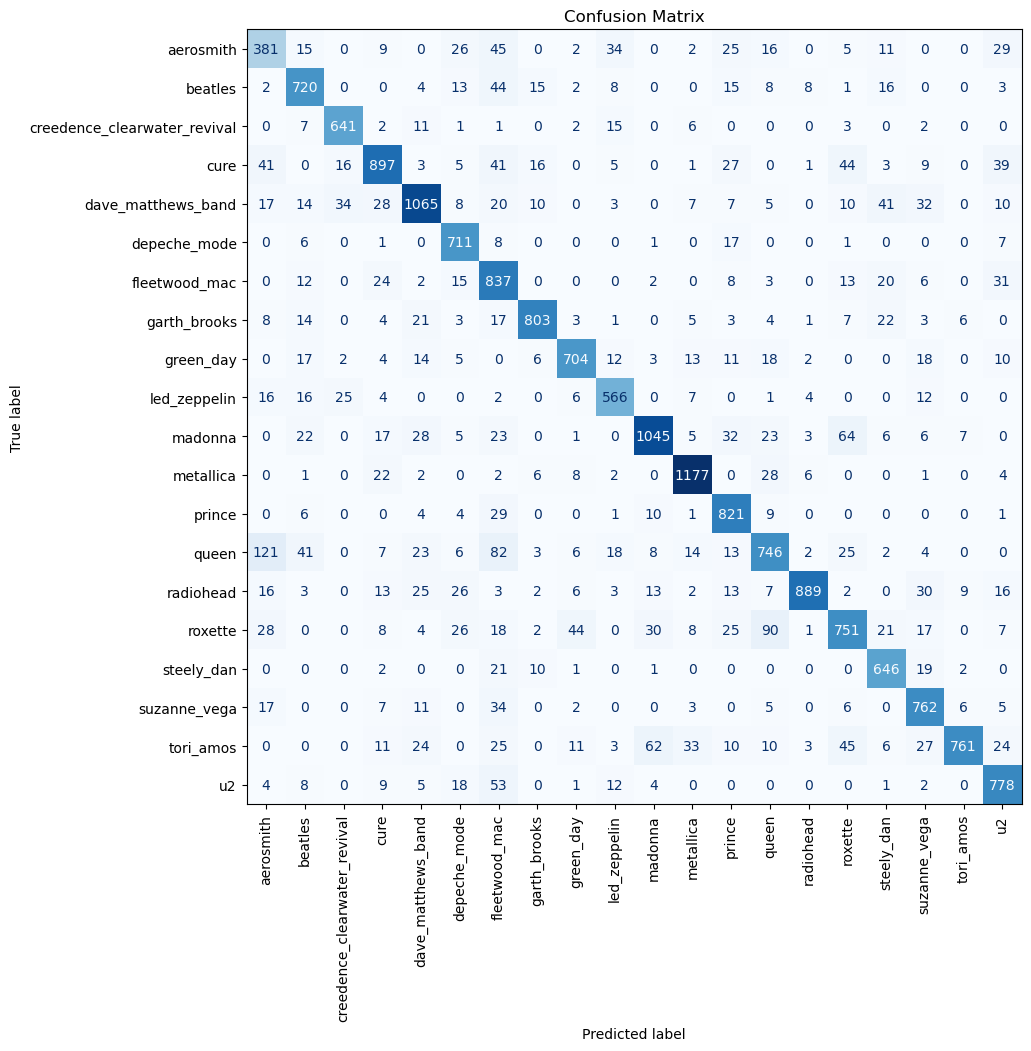

In [33]:
fig, ax = plt.subplots(figsize=(10,20))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax, colorbar=False)
plt.title('Confusion Matrix')
plt.show()

In [42]:
for i, name in enumerate(encoder.categories_[0]):
    print(i,name)

0 aerosmith
1 beatles
2 creedence_clearwater_revival
3 cure
4 dave_matthews_band
5 depeche_mode
6 fleetwood_mac
7 garth_brooks
8 green_day
9 led_zeppelin
10 madonna
11 metallica
12 prince
13 queen
14 radiohead
15 roxette
16 steely_dan
17 suzanne_vega
18 tori_amos
19 u2


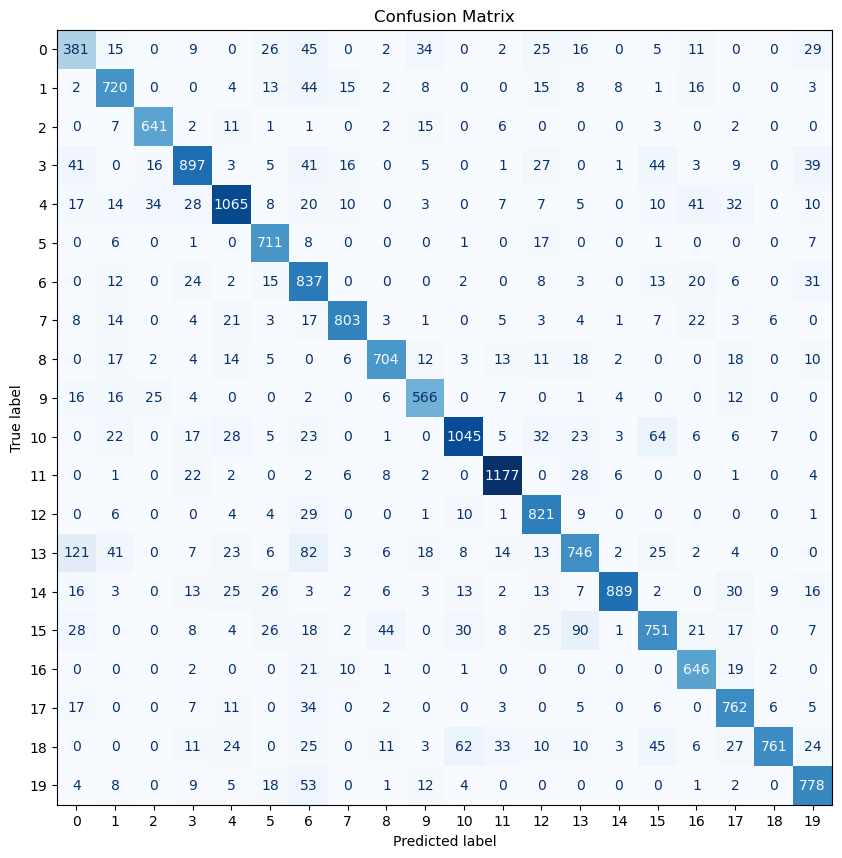

In [41]:
  # List of artist names
labels = list(encoder.categories_[0])  # List of artist names
cm1 = confusion_matrix(response["all_labels"], response["all_predictions"])
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm)

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
fig, ax = plt.subplots(figsize=(10,20))
disp1.plot(cmap=plt.cm.Blues,  ax=ax, colorbar=False)
plt.title('Confusion Matrix')
plt.show()

In [217]:
train_df[train_df.label == "metallica"].path[82394]

'./dataset/train/metallica-Phantom_Lord-3sec-36.plk.gz'

In [232]:
label = "metallica"
path = train_df[train_df.label == label].path[7337]

In [233]:
filter = encoder.categories_[0] == label
filter_encoded = [1 if i else 0 for i in filter]
filter_encoded = np.array(filter_encoded)

In [234]:
encoder.categories_[0][filter_encoded.argmax()]

'metallica'

In [235]:


with gzip.open(path, 'rb') as f:
    decompressed_data = pickle.load(f)
    decompressed_data = decompressed_data['spectrogram']


decompressed_data = torch.tensor(decompressed_data, dtype=torch.float ).to(device)
labels = torch.tensor(filter_encoded, dtype=torch.float ).to(device)
decompressed_data = decompressed_data.unsqueeze(0)
decompressed_data.size()
           

torch.Size([1, 128, 94])

In [236]:
with torch.no_grad(): 
    output, attn_output_weights = model(decompressed_data)
    predictions = torch.argmax(output, dim=1)
    output_array = predictions.cpu().numpy()

    attn_output = attn_output_weights.squeeze(0).cpu().numpy()

In [244]:
encoder.categories_[0][output_array[0]]

'metallica'

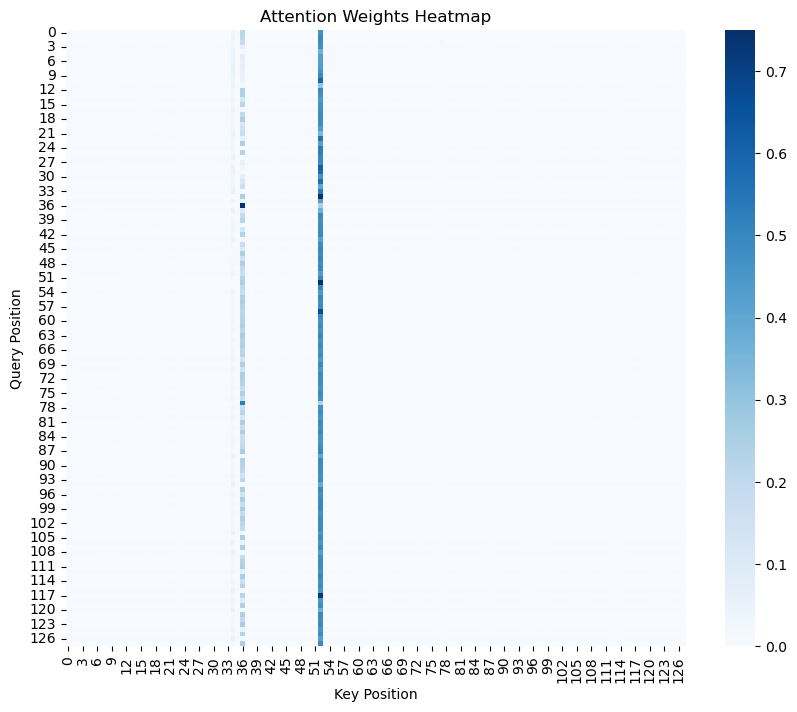

In [238]:
plt.figure(figsize=(10, 8))
sns.heatmap(attn_output, cmap=plt.cm.Blues)
plt.title('Attention Weights Heatmap')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.show()

In [43]:
label1 = "madonna"
path1 = train_df[train_df.label == label1].path[3896]

In [44]:
path1

'./dataset/train/madonna-Gone-3sec-72.plk.gz'

In [252]:
filter = encoder.categories_[0] == label1
filter_encoded = [1 if i else 0 for i in filter]
filter_encoded = np.array(filter_encoded)
encoder.categories_[0][filter_encoded.argmax()]

'madonna'

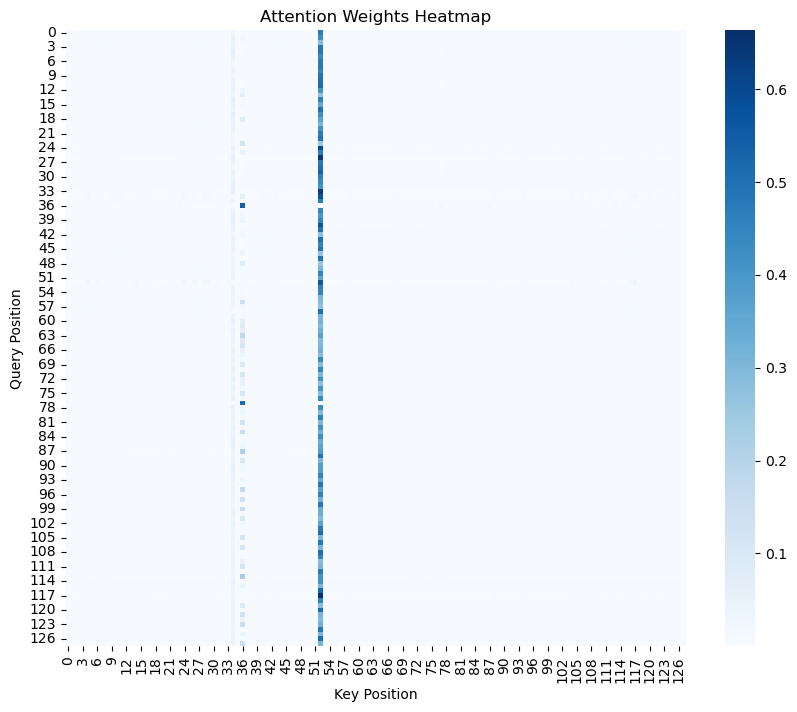

In [254]:

with gzip.open(path1, 'rb') as f:
    decompressed_data = pickle.load(f)
    decompressed_data = decompressed_data['spectrogram']


decompressed_data = torch.tensor(decompressed_data, dtype=torch.float ).to(device)
labels = torch.tensor(filter_encoded, dtype=torch.float ).to(device)
decompressed_data = decompressed_data.unsqueeze(0)
decompressed_data.size()

with torch.no_grad(): 
    output, attn_output_weights = model(decompressed_data)
    predictions = torch.argmax(output, dim=1)
    output_array = predictions.cpu().numpy()

    attn_output = attn_output_weights.squeeze(0).cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attn_output, cmap=plt.cm.Blues)
plt.title('Attention Weights Heatmap')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.show()

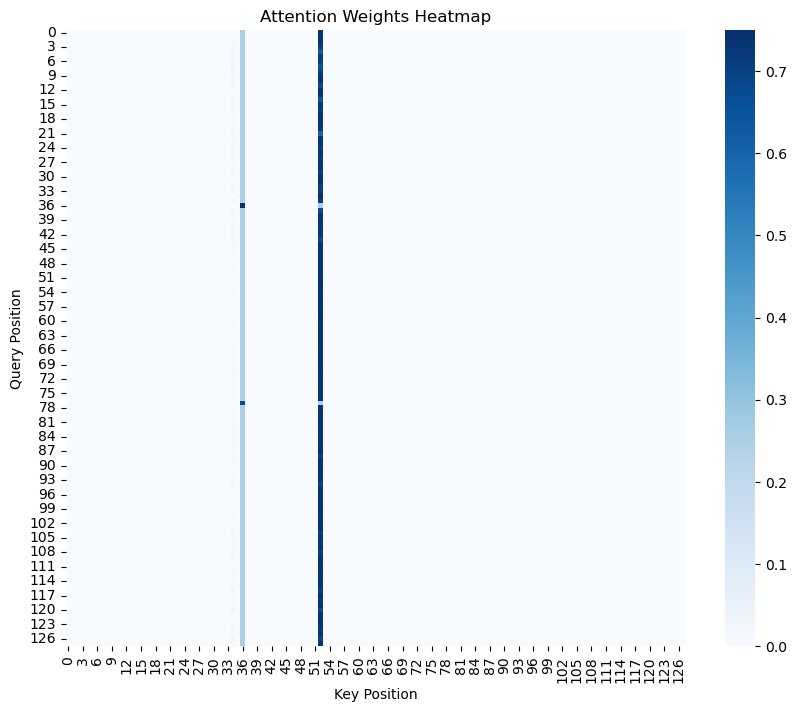

In [262]:
path1label1 = "roxette"
path1 = test_df[test_df.label == label1].path[3181]
filter = encoder.categories_[0] == label1
filter_encoded = [1 if i else 0 for i in filter]
filter_encoded = np.array(filter_encoded)
encoder.categories_[0][filter_encoded.argmax()]

with gzip.open(path1, 'rb') as f:
    decompressed_data = pickle.load(f)
    decompressed_data = decompressed_data['spectrogram']


decompressed_data = torch.tensor(decompressed_data, dtype=torch.float ).to(device)
labels = torch.tensor(filter_encoded, dtype=torch.float ).to(device)
decompressed_data = decompressed_data.unsqueeze(0)
decompressed_data.size()

with torch.no_grad(): 
    output, attn_output_weights = model(decompressed_data)
    predictions = torch.argmax(output, dim=1)
    output_array = predictions.cpu().numpy()

    attn_output = attn_output_weights.squeeze(0).cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attn_output, cmap=plt.cm.Blues)
plt.title('Attention Weights Heatmap')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.show()


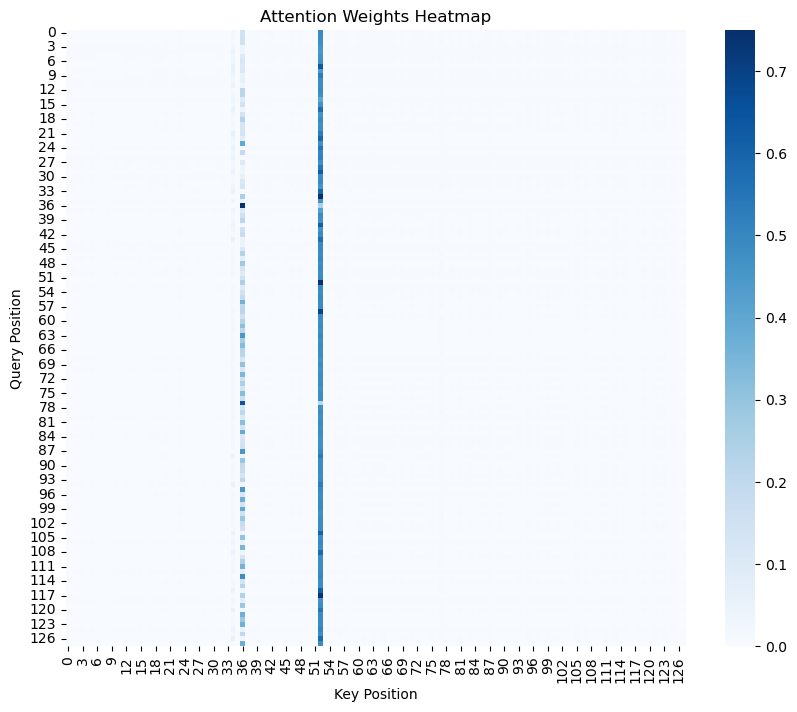

In [269]:
path1label1 = "prince"
path1 = test_df[test_df.label == label1].path[15371]
filter = encoder.categories_[0] == label1
filter_encoded = [1 if i else 0 for i in filter]
filter_encoded = np.array(filter_encoded)
encoder.categories_[0][filter_encoded.argmax()]

with gzip.open(path1, 'rb') as f:
    decompressed_data = pickle.load(f)
    decompressed_data = decompressed_data['spectrogram']


decompressed_data = torch.tensor(decompressed_data, dtype=torch.float ).to(device)
labels = torch.tensor(filter_encoded, dtype=torch.float ).to(device)
decompressed_data = decompressed_data.unsqueeze(0)
decompressed_data.size()

with torch.no_grad(): 
    output, attn_output_weights = model(decompressed_data)
    predictions = torch.argmax(output, dim=1)
    output_array = predictions.cpu().numpy()

    attn_output = attn_output_weights.squeeze(0).cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attn_output, cmap=plt.cm.Blues)
plt.title('Attention Weights Heatmap')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.show()


# Generate t-SNE

In [284]:
model.module.module.cnn

CNN(
  (cnn): Sequential(
    (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act_1): ELU(alpha=1.0)
    (max_pooling_1): MaxPool2d(kernel_size=(4, 4), stride=(4, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (dropout_1): Dropout(p=0.2, inplace=False)
    (conv_2): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (act_2): ELU(alpha=1.0)
    (max_pooling_2): MaxPool2d(kernel_size=(4, 2), stride=(4, 1), padding=(1, 1), dilation=1, ceil_mode=False)
    (dropout_2): Dropout(p=0.2, inplace=False)
    (conv_3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (act_3): ELU(alpha=1.0)
    (max_pooling_3): MaxPool2d(kernel_size=(4, 2), stride=(4, 1), padding=(0, 0), dilation=1, ceil_mode=False)
    (dropout_3): Dropout(p=0.2, inplace=False)
  )
)

create new Model without the 20 classes at the end

In [289]:
from torch.autograd import Variable

class CNN(nn.Module):
    
    def __init__(self, in_channels:int, out_channels:int)-> Tensor:
        super(CNN, self).__init__()
        padding = [(1,1), (0,0)]
        number_filters = [int(64), int(64),  out_channels]

        self.cnn = nn.Sequential(OrderedDict([
            ("batch_norm",nn.BatchNorm2d(1)),
            ("conv_1", nn.Conv2d(in_channels = in_channels, out_channels=number_filters[0], kernel_size=(3,3), padding=padding[0])),
            ("act_1", nn.ELU()),
            ("max_pooling_1",nn.MaxPool2d(kernel_size=(4,4), stride=(4,2), padding = padding[0])),
            ("dropout_1",nn.Dropout(p = 0.2)),

            ("conv_2", nn.Conv2d(in_channels = number_filters[0], out_channels=number_filters[1], kernel_size=(4,4), padding=padding[0])),
            ("act_2", nn.ELU()),
            ("max_pooling_2",nn.MaxPool2d(kernel_size=(4,2), stride=(4,1), padding = padding[0])),
            ("dropout_2",nn.Dropout(p = 0.2)),

            ("conv_3", nn.Conv2d(in_channels = number_filters[1], out_channels=number_filters[2], kernel_size=(4,4), padding=padding[0])),
            ("act_3", nn.ELU()),
            ("max_pooling_3",nn.MaxPool2d(kernel_size=(4,2), stride=(4,1), padding = padding[1])),
            ("dropout_3",nn.Dropout(p = 0.2)),

        ]))


    def forward(self, src:Tensor) -> Tensor:
        
        src = src.unsqueeze(1)
        src =  self.cnn(src)
        src = src.squeeze(2)   
        return src 
        


class PositionalEncoding(nn.Module):
    def __init__(self, d_model:int, max_len:int=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        x = x + self.encoding[:, :x.size(1), :].to(device)
        return x
    



class SelfAttentionClassifier(nn.Module):
    def __init__(self, max_seq_len, embedding_dim, num_heads, dropout=0.3):
        super(SelfAttentionClassifier, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Linear(max_seq_len, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim) 
        self.self_attention = nn.MultiheadAttention(embed_dim = embedding_dim, 
                                                    num_heads = num_heads, 
                                                    dropout = dropout)
        
        
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(embedding_dim)
        

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.embedding_dim)
        # src = self.norm(src)
        src = self.pos_encoder(src)
        src = src.permute(2,0,1)
        attn_output, attn_output_weights = self.self_attention(src, src, src)  # Self-attention
        attn_output = attn_output.mean(dim=0) 
        attn_output = self.dropout(attn_output)
        
        return attn_output, attn_output_weights

    


class VisualEncoderWithoutFC(nn.Module):
    def __init__(self, 
                 in_channels_cnn: int, 
                 out_channels_cnn:int, 
                 num_heads : int=2,
                
                 )-> Tensor:
        
        super(VisualEncoderWithoutFC, self).__init__()
        self.cnn = CNN(in_channels_cnn, out_channels_cnn)
        
        self.encoder = SelfAttentionClassifier(max_seq_len = 45, 
                                          embedding_dim = out_channels_cnn, 
                                          num_heads = num_heads)
                
    def forward(self, src: torch.Tensor):
        src = self.cnn(src) 
        src, attn_output_weights = self.encoder(src)
        return src, attn_output_weights
       

In [290]:

state_dict = model.state_dict()

In [291]:
model_config = {
    "in_channels_cnn" : int(1),
    "out_channels_cnn" : int(128),
    "num_heads" : int(4)
}
new_model = VisualEncoderWithoutFC(**model_config)

In [294]:

state_dict_newModel = new_model.state_dict()

copy weights of the model loaded to a new the model 

In [318]:
new_model.load_state_dict({k.split("module.module.")[1]: v for k, v in state_dict.items() if 'fc' not in k})

<All keys matched successfully>

In [320]:
new_model.to(device)

VisualEncoderWithoutFC(
  (cnn): CNN(
    (cnn): Sequential(
      (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act_1): ELU(alpha=1.0)
      (max_pooling_1): MaxPool2d(kernel_size=(4, 4), stride=(4, 2), padding=(1, 1), dilation=1, ceil_mode=False)
      (dropout_1): Dropout(p=0.2, inplace=False)
      (conv_2): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (act_2): ELU(alpha=1.0)
      (max_pooling_2): MaxPool2d(kernel_size=(4, 2), stride=(4, 1), padding=(1, 1), dilation=1, ceil_mode=False)
      (dropout_2): Dropout(p=0.2, inplace=False)
      (conv_3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (act_3): ELU(alpha=1.0)
      (max_pooling_3): MaxPool2d(kernel_size=(4, 2), stride=(4, 1), padding=(0, 0), dilation=1, ceil_mode=False)
      (dropout_3): Dropout(p=0.2, inplace=False)
    )
  )
  (encod

High Dimensionality Model for Test data

In [348]:
response = {
    "labels" : list([]),
    "predictions" : list([])
}
    


# Evaluate data for one epoch
new_model.eval()
with torch.no_grad(): #  not to compute or store gradients
    for _, batch in enumerate(test_dataLoader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, labels = batch #unpack from Dataloader
        output, _ = new_model(input_ids)

        labels_ = torch.argmax(labels, dim=1)

        response["labels"].extend(labels_.cpu().numpy())
        response["predictions"].extend(output.cpu().numpy())

    
      
# clean memory
gc.collect()
torch.cuda.empty_cache()



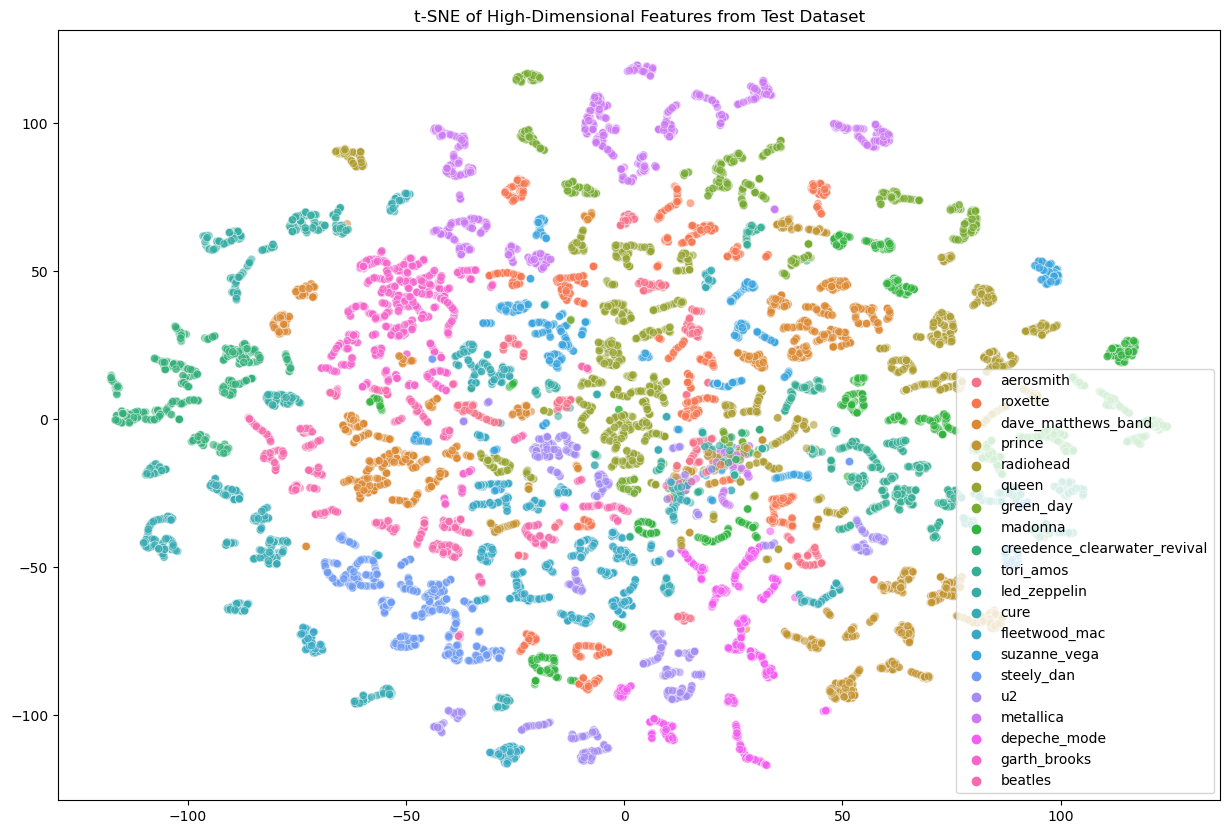

In [350]:

labels_list = list(encoder.categories_[0]) 
labels = np.array(np.array([labels_list[i] for i in response['labels']]))
predictions = np.array(response['predictions'])


X_tsne = manifold.TSNE(n_components=2,  random_state=42).fit_transform(predictions)
plt.figure(figsize=(15, 10))
sns.scatterplot(
    x=X_tsne[:,0], 
    y=X_tsne[:,1],
    hue=labels,
    palette=sns.color_palette("husl", len(labels_list)),
    legend="full",
    alpha=0.6
)
plt.title('t-SNE of High-Dimensional Features from Test Dataset')
plt.show()

high dimensionality for train Model

In [351]:
response = {
    "labels" : list([]),
    "predictions" : list([])
}
    


# Evaluate data for one epoch
new_model.eval()
with torch.no_grad(): #  not to compute or store gradients
    for _, batch in enumerate(train_dataLoader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, labels = batch #unpack from Dataloader
        output, _ = new_model(input_ids)

        labels_ = torch.argmax(labels, dim=1)

        response["labels"].extend(labels_.cpu().numpy())
        response["predictions"].extend(output.cpu().numpy())

    
      
# clean memory
gc.collect()
torch.cuda.empty_cache()


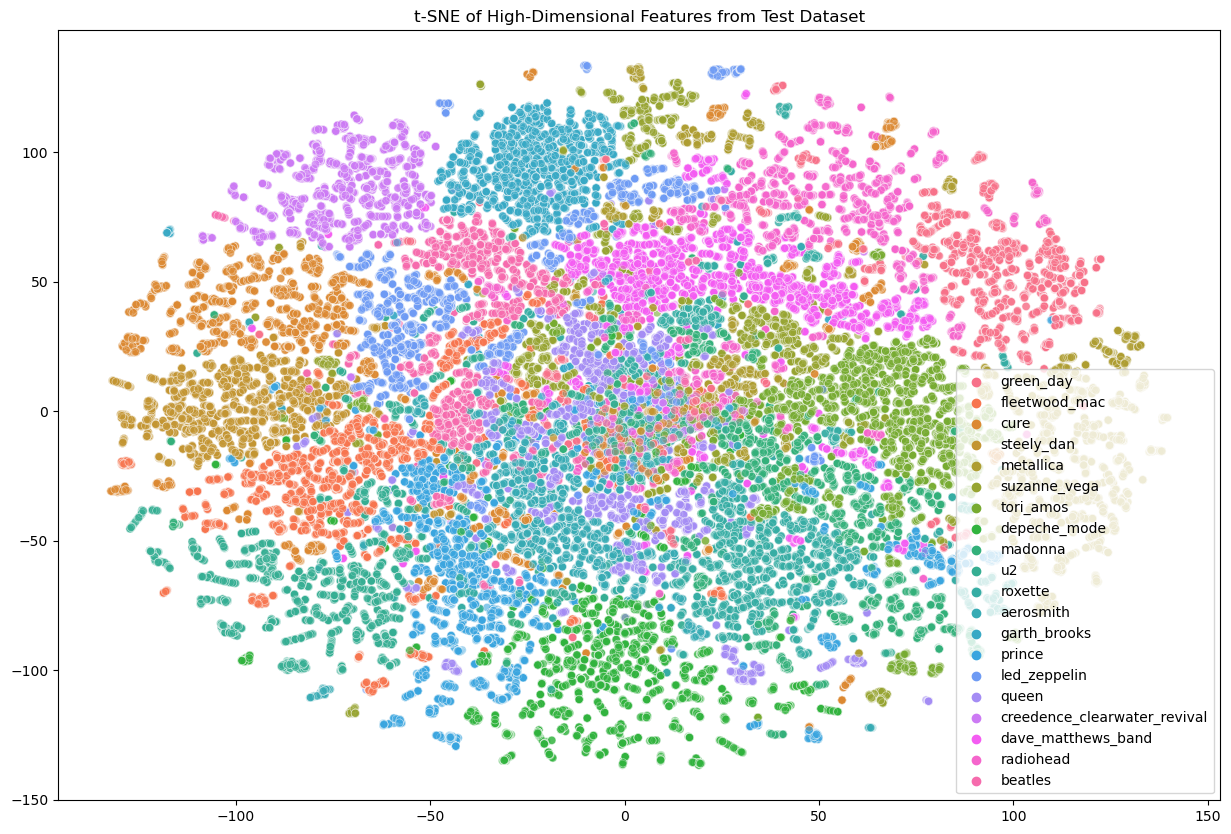

In [352]:

labels_list = list(encoder.categories_[0]) 
labels = np.array(np.array([labels_list[i] for i in response['labels']]))
predictions = np.array(response['predictions'])


X_tsne = manifold.TSNE(n_components=2,  random_state=42).fit_transform(predictions)
plt.figure(figsize=(15, 10))
sns.scatterplot(
    x=X_tsne[:,0], 
    y=X_tsne[:,1],
    hue=labels,
    palette=sns.color_palette("husl", len(labels_list)),
    legend="full",
    alpha=0.6
)
plt.title('t-SNE of High-Dimensional Features from Test Dataset')
plt.show()